
# Workers' Compensation Claims — End-to-End ML (Kaggle Dataset)

This notebook shows how to go from **business question → production approach** using a Kaggle dataset.
We will predict claim outcomes and/or flag high-cost claims, following a practical ML workflow:

1. Frame the business & ML problem  
2. Load the data  
3. Explore & visualize  
4. Prepare & engineer features  
5. Train baseline models (regression & classification)  
6. Fine-tune with cross-validation  
7. Present results (metrics, feature importances, ROC)  
8. Discuss deployment: launch, monitor, maintain

> You can upload the **full Kaggle CSV**. For quick testing, a small sample CSV is included.



## 1) Look at the Big Picture — Frame the Problem

**Business questions (examples):**
- *Regression:* What will the **ultimate incurred claim cost** be?  
- *Classification:* Will the claim be **high-cost** (e.g., top 10%)?

**Why it matters:**
- Better reserving and budgeting.
- Early triage and investigation of risky claims.
- Faster processing of low-risk claims.

**ML setup:**
- Supervised learning on historical claims.
- Target: `UltimateIncurredClaimCost` (regression) or `HighCost` (classification).



## 2) Get the Data — Load the CSV

- **Option A:** Upload your Kaggle CSV in the left Files pane, then set `csv_path` below.
- **Option B:** Use the included mini sample to verify the pipeline works end-to-end.


In [2]:

import pandas as pd

# Set to your uploaded Kaggle CSV file name, e.g.:
# csv_path = "/content/<your_kaggle_file>.csv"
# For demo, we'll start with the small sample:
csv_path = "datasets/easy_peasy.csv"

df = pd.read_csv(csv_path)
df.head()


,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,...,ClaimDescriptionKeyword_4,ClaimDescriptionKeyword_5,ClaimDescriptionKeyword_6,ClaimDescriptionKeyword_7,ClaimDescriptionKeyword_8,ClaimDescriptionKeyword_9,ClaimDescriptionKeyword_10,ClaimDescriptionKeyword_11,InitialIncurredClaimsCost,UltimateIncurredClaimCost
0,WC8285054,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,...,-0.137039,1.634239,-1.436096,-0.757871,-1.091920,0.880767,0.168497,1.161294,1500,4748.203388
1,WC6982224,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,...,1.788994,0.459482,0.662757,-0.240500,-0.162451,0.665242,0.844019,-1.305332,5500,6326.285819
2,WC5481426,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,...,-0.045712,-0.192742,-0.047881,0.139051,-0.339551,-0.386420,-0.397919,-0.259750,1700,2293.949087
3,WC9775968,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,...,0.067053,1.105471,0.609462,1.495272,-0.527257,-0.187209,-0.857031,-0.343594,15000,17786.487170
4,WC2634037,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,...,-0.647481,-1.413973,-0.807369,0.243139,1.031237,0.366183,0.427945,-0.038234,2800,4014.002925



## 3) Explore & Visualize
We'll parse dates, engineer simple time features, and look at distributions and relationships.


In [3]:

import numpy as np

# Parse ISO timestamps
for col in ["DateTimeOfAccident", "DateReported"]:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# Feature: Days between accident and report
df["DaysToReport"] = (df["DateReported"] - df["DateTimeOfAccident"]).dt.days

# Time features
df["AccidentYear"] = df["DateTimeOfAccident"].dt.year
df["AccidentMonth"] = df["DateTimeOfAccident"].dt.month

df[["DateTimeOfAccident","DateReported","DaysToReport","AccidentYear","AccidentMonth"]].head()


,DateTimeOfAccident,DateReported,DaysToReport,AccidentYear,AccidentMonth
0,2002-04-09 07:00:00+00:00,2002-07-05 00:00:00+00:00,86,2002,4
1,1999-01-07 11:00:00+00:00,1999-01-20 00:00:00+00:00,12,1999,1
2,1996-03-25 00:00:00+00:00,1996-04-14 00:00:00+00:00,20,1996,3
3,2005-06-22 13:00:00+00:00,2005-07-22 00:00:00+00:00,29,2005,6
4,1990-08-29 08:00:00+00:00,1990-09-27 00:00:00+00:00,28,1990,8


In [4]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   ClaimNumber                 54000 non-null  object             
 1   DateTimeOfAccident          54000 non-null  datetime64[ns, UTC]
 2   DateReported                54000 non-null  datetime64[ns, UTC]
 3   Age                         54000 non-null  int64              
 4   Gender                      54000 non-null  object             
 5   MaritalStatus               53971 non-null  object             
 6   DependentChildren           54000 non-null  int64              
 7   DependentsOther             54000 non-null  int64              
 8   WeeklyWages                 54000 non-null  float64            
 9   PartTimeFullTime            54000 non-null  object             
 10  HoursWorkedPerWeek          54000 non-null  float64       

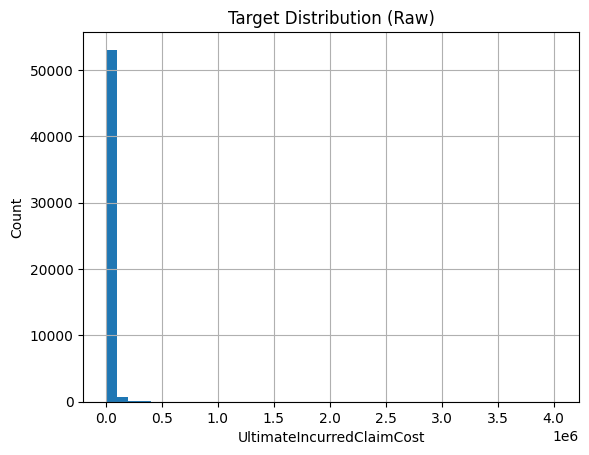

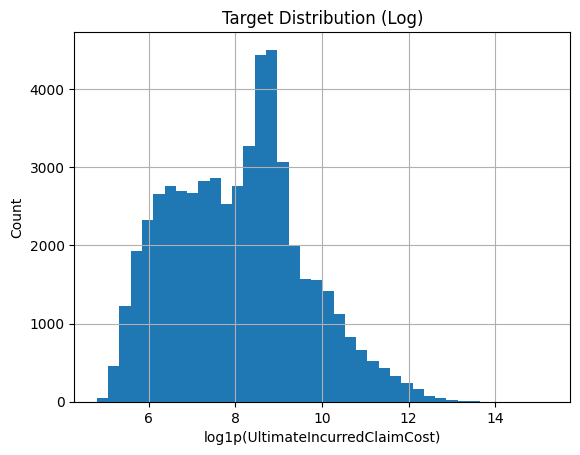

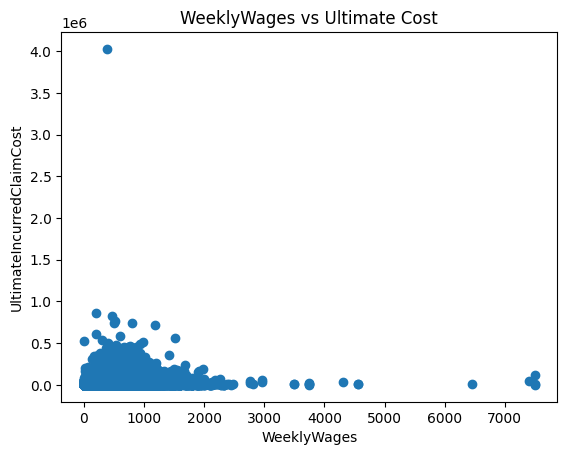

In [5]:

import matplotlib.pyplot as plt

# Target distribution (if available)
if "UltimateIncurredClaimCost" in df.columns:
    plt.figure()
    df["UltimateIncurredClaimCost"].hist(bins=40)
    plt.xlabel("UltimateIncurredClaimCost")
    plt.ylabel("Count")
    plt.title("Target Distribution (Raw)")
    plt.show()

    plt.figure()
    import numpy as np
    np.log1p(df["UltimateIncurredClaimCost"]).hist(bins=40)
    plt.xlabel("log1p(UltimateIncurredClaimCost)")
    plt.ylabel("Count")
    plt.title("Target Distribution (Log)")
    plt.show()

# Relationship: WeeklyWages vs Ultimate Cost
if {"WeeklyWages","UltimateIncurredClaimCost"} <= set(df.columns):
    plt.figure()
    plt.scatter(df["WeeklyWages"], df["UltimateIncurredClaimCost"])
    plt.xlabel("WeeklyWages")
    plt.ylabel("UltimateIncurredClaimCost")
    plt.title("WeeklyWages vs Ultimate Cost")
    plt.show()


In [6]:

# Correlation (numerical columns only)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if "UltimateIncurredClaimCost" in df.columns:
    corr = df[num_cols].corr(numeric_only=True)
    corr_top = corr["UltimateIncurredClaimCost"].sort_values(ascending=False).head(10)
    display(corr_top.to_frame("corr_with_target"))
else:
    print("UltimateIncurredClaimCost not found; skipping correlation view.")


,corr_with_target
UltimateIncurredClaimCost,1.000000
InitialIncurredClaimsCost,0.394991
AccidentYear,0.161759
WeeklyWages,0.151695
ClaimDescriptionKeyword_1,0.133857
Age,0.102716
ClaimDescriptionKeyword_0,0.060385
ClaimDescriptionKeyword_11,0.044046
ClaimDescriptionKeyword_7,0.038026
DependentChildren,0.033450



## 4) Prepare the Data
- Select features and target.
- Handle categorical variables via one-hot encoding.
- Scale numerical features for linear models.
- Split into train/test.


In [7]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Classification target (high cost = top 10%)
if "UltimateIncurredClaimCost" in df.columns:
    threshold = df["UltimateIncurredClaimCost"].quantile(0.9)
    df["HighCost"] = (df["UltimateIncurredClaimCost"] >= threshold).astype(int)

drop_cols = ["ClaimNumber","DateTimeOfAccident","DateReported"]
target_reg = "UltimateIncurredClaimCost"
target_clf = "HighCost" if "HighCost" in df.columns else None

feature_df = df.drop(columns=[c for c in drop_cols if c in df.columns])
X = feature_df.drop(columns=[t for t in [target_reg, target_clf] if t in feature_df.columns])
y_reg = df[target_reg] if target_reg in df.columns else None
y_clf = df[target_clf] if target_clf else None

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
if y_clf is not None:
    _, _, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

len(X_train), len(X_test)


(43200, 10800)


## 5) Select & Train Baseline Models
- **Regression:** Linear Regression and Random Forest Regressor
- **Classification:** Logistic Regression and Random Forest Classifier


In [9]:

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Regression baselines
reg_lin = Pipeline([("prep", preprocessor), ("model", LinearRegression())])
reg_lin.fit(X_train, y_train_reg)
pred_lin = reg_lin.predict(X_test)
print("Regression — Linear: RMSE={:.2f}, MAE={:.2f}, R2={:.3f}".format(
    np.sqrt(mean_squared_error(y_test_reg, pred_lin)),
    mean_absolute_error(y_test_reg, pred_lin),
    r2_score(y_test_reg, pred_lin)
))

reg_rf = Pipeline([("prep", preprocessor), ("model", RandomForestRegressor(random_state=42))])
reg_rf.fit(X_train, y_train_reg)
pred_rf = reg_rf.predict(X_test)
print("Regression — RF:     RMSE={:.2f}, MAE={:.2f}, R2={:.3f}".format(
    np.sqrt(mean_squared_error(y_test_reg, pred_rf)),
    mean_absolute_error(y_test_reg, pred_rf),
    r2_score(y_test_reg, pred_rf)
))


Regression — Linear: RMSE=26398.08, MAE=8861.60, R2=0.232
Regression — RF:     RMSE=26955.97, MAE=8467.67, R2=0.200
Regression — RF:     RMSE=26955.97, MAE=8467.67, R2=0.200


Classification — Logistic AUC: 0.917
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      9741
           1       0.82      0.54      0.65      1059

    accuracy                           0.94     10800
   macro avg       0.89      0.76      0.81     10800
weighted avg       0.94      0.94      0.94     10800

Classification — RF AUC: 0.902
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      9741
           1       0.83      0.55      0.66      1059

    accuracy                           0.94     10800
   macro avg       0.89      0.77      0.82     10800
weighted avg       0.94      0.94      0.94     10800

Classification — RF AUC: 0.902
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      9741
           1       0.83      0.55      0.66      1059

    accuracy                           0.94     10800
   macro avg       0.89      

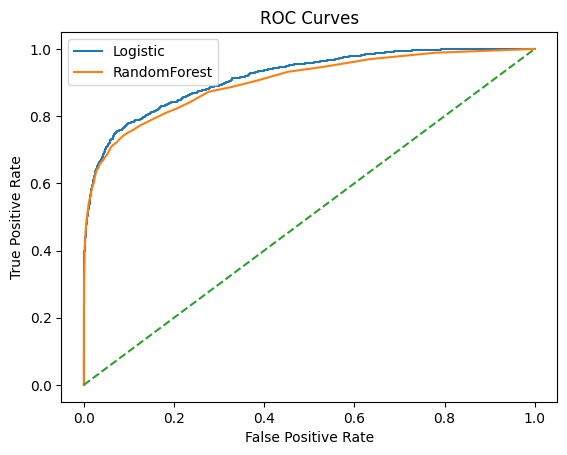

In [13]:

# Classification baselines
if "HighCost" in df.columns and df["HighCost"].nunique() == 2:
    clf_log = Pipeline([("prep", preprocessor), ("model", LogisticRegression(max_iter=200))])
    clf_log.fit(X_train, y_train_clf)
    proba_log = clf_log.predict_proba(X_test)[:,1]
    pred_log = (proba_log >= 0.5).astype(int)
    print("Classification — Logistic AUC: {:.3f}".format(roc_auc_score(y_test_clf, proba_log)))
    print(classification_report(y_test_clf, pred_log))

    clf_rf = Pipeline([("prep", preprocessor), ("model", RandomForestClassifier(random_state=42))])
    clf_rf.fit(X_train, y_train_clf)
    proba_rf = clf_rf.predict_proba(X_test)[:,1]
    pred_rf = (proba_rf >= 0.5).astype(int)
    print("Classification — RF AUC: {:.3f}".format(roc_auc_score(y_test_clf, proba_rf)))
    print(classification_report(y_test_clf, pred_rf))

    # ROC curves
    plt.figure()
    fpr_log, tpr_log, _ = roc_curve(y_test_clf, proba_log)
    fpr_rf, tpr_rf, _ = roc_curve(y_test_clf, proba_rf)
    plt.plot(fpr_log, tpr_log, label="Logistic")
    plt.plot(fpr_rf, tpr_rf, label="RandomForest")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()
else:
    print("Classification target not available; skipping classification section.")



## 6) Fine-Tune Your Model (Randomized Search)
Small search for Random Forest — both regression and classification.


In [10]:

from sklearn.model_selection import RandomizedSearchCV

rf_reg = Pipeline([("prep", preprocessor), ("model", RandomForestRegressor(random_state=42))])
param_dist_reg = {
    "model__n_estimators": [100, 200, 400],
    "model__max_depth": [None, 10, 20, 40],
    "model__min_samples_split": [2, 5, 10]
}
# Use neg_mean_squared_error for broad version compatibility; we'll report RMSE on the test set below.
search_reg = RandomizedSearchCV(
    rf_reg,
    param_distributions=param_dist_reg,
    n_iter=6,
    scoring="neg_mean_squared_error",
    cv=3,
    random_state=42,
    n_jobs=-1
)
search_reg.fit(X_train, y_train_reg)
best_reg = search_reg.best_estimator_
print("Best reg params:", search_reg.best_params_)


Best reg params: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__max_depth': 10}


In [11]:

from sklearn.metrics import mean_squared_error
import numpy as np

pred_best = best_reg.predict(X_test)
print("Best RF Test RMSE:", np.sqrt(mean_squared_error(y_test_reg, pred_best)))


Best RF Test RMSE: 26252.327297657648


In [14]:

if "HighCost" in df.columns and df["HighCost"].nunique() == 2:
    rf_clf = Pipeline([("prep", preprocessor), ("model", RandomForestClassifier(random_state=42))])
    param_dist_clf = {
        "model__n_estimators": [100, 200, 400],
        "model__max_depth": [None, 10, 20, 40],
        "model__min_samples_split": [2, 5, 10]
    }
    search_clf = RandomizedSearchCV(rf_clf, param_distributions=param_dist_clf, n_iter=6,
                                    scoring="roc_auc", cv=3, random_state=42, n_jobs=-1)
    search_clf.fit(X_train, y_train_clf)
    best_clf = search_clf.best_estimator_
    print("Best clf params:", search_clf.best_params_)

    from sklearn.metrics import roc_auc_score
    proba_best = best_clf.predict_proba(X_test)[:,1]
    print("Best RF Test AUC:", roc_auc_score(y_test_clf, proba_best))


Best clf params: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__max_depth': 10}
Best RF Test AUC: 0.9084320734211545



## 7) Present Your Solution — Drivers & Insights
We show feature importances (top 10) for tuned models.


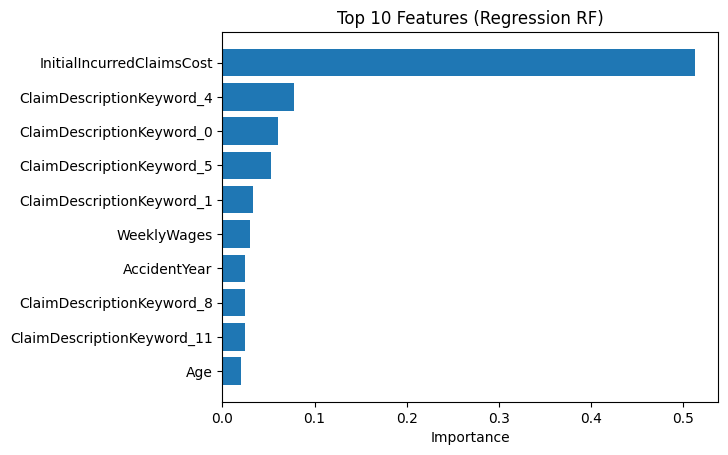

In [15]:

import numpy as np
import matplotlib.pyplot as plt

def get_feature_names(prep, num_cols, cat_cols):
    num_features = list(num_cols)
    ohe = None
    try:
        ohe = prep.named_transformers_["cat"]
    except Exception:
        for name, trans, cols in prep.transformers_:
            if name == "cat":
                ohe = trans
                break
    if hasattr(ohe, "get_feature_names_out"):
        cat_features = list(ohe.get_feature_names_out(cat_cols))
    else:
        cat_features = []
    return num_features + cat_features

num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Regression importances
feature_names = get_feature_names(best_reg.named_steps["prep"], num_cols, cat_cols)
importances = best_reg.named_steps["model"].feature_importances_
order = np.argsort(importances)[::-1][:10]

plt.figure()
plt.barh([feature_names[i] for i in order][::-1], importances[order][::-1])
plt.xlabel("Importance")
plt.title("Top 10 Features (Regression RF)")
plt.show()


In [ ]:

# Classification importances
if "HighCost" in df.columns and df["HighCost"].nunique() == 2:
    feature_names = get_feature_names(best_clf.named_steps["prep"], num_cols, cat_cols)
    importances = best_clf.named_steps["model"].feature_importances_
    order = np.argsort(importances)[::-1][:10]

    plt.figure()
    plt.barh([feature_names[i] for i in order][::-1], importances[order][::-1])
    plt.xlabel("Importance")
    plt.title("Top 10 Features (Classification RF)")
    plt.show()



## 8) Launch, Monitor, and Maintain — Production Approach

**How to ship this at WCF:**
1. Save the tuned pipeline using `joblib` (it includes preprocessing + model).
2. Expose a prediction endpoint or batch job to score new claims.
3. Store predictions with timestamps; route high-risk claims for human review.
4. Monitor model drift and performance; retrain monthly/quarterly.
5. Add governance: access controls, audit logs, bias monitoring by demographic segments.



## **Extra Analysis Ideas**

In this section, we go beyond the basic regression/classification models and explore additional analytical techniques:

1. **Clustering:** Segment claims based on injury description keyword embeddings to find patterns in claim types and costs.
2. **Time-Series Trend Analysis:** Explore how claim costs and frequency evolve over time.
3. **Scenario Simulation:** Estimate potential savings if the reporting delay is reduced.


In [ ]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Select the claim description keyword columns
keyword_cols = [col for col in df.columns if col.startswith("ClaimDescriptionKeyword_")]
X_keywords = df[keyword_cols]

# Run KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['ClaimCluster'] = kmeans.fit_predict(X_keywords)

# Cluster analysis: average cost per cluster
cluster_costs = df.groupby('ClaimCluster')['UltimateIncurredClaimCost'].mean()
print("Average cost per cluster:\n", cluster_costs)

# Visualize clusters using first two PCA components
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X_keywords)

plt.scatter(components[:,0], components[:,1], c=df['ClaimCluster'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Claim Clusters (based on keywords)')
plt.show()


In [ ]:

# Time-series: average cost per accident year
df['AccidentYear'] = df['DateTimeOfAccident'].dt.year
yearly_costs = df.groupby('AccidentYear')['UltimateIncurredClaimCost'].mean()

yearly_costs.plot(marker='o')
plt.ylabel('Average Claim Cost')
plt.title('Average Claim Cost by Accident Year')
plt.grid(True)
plt.show()

# Claim frequency per year
yearly_counts = df.groupby('AccidentYear').size()
yearly_counts.plot(marker='s', color='orange')
plt.ylabel('Number of Claims')
plt.title('Number of Claims by Accident Year')
plt.grid(True)
plt.show()


In [ ]:

# Scenario: Reduce DaysToReport to <= 7 days for all claims
df['DaysToReport'] = (df['DateReported'] - df['DateTimeOfAccident']).dt.days
baseline_avg_cost = df['UltimateIncurredClaimCost'].mean()

# Assume that for late-reported claims (>7 days), cost could be reduced by 5%
df['SimulatedCost'] = df.apply(lambda row: row['UltimateIncurredClaimCost'] * 0.95 if row['DaysToReport'] > 7 else row['UltimateIncurredClaimCost'], axis=1)

simulated_avg_cost = df['SimulatedCost'].mean()
savings = baseline_avg_cost - simulated_avg_cost

print(f"Baseline avg cost: {baseline_avg_cost:,.2f}")
print(f"Simulated avg cost (report <= 7 days): {simulated_avg_cost:,.2f}")
print(f"Estimated savings per claim: {savings:,.2f}")
print(f"Estimated annual savings (assuming {len(df)} claims/year): {savings * len(df):,.2f}")
